In [129]:
#  Multi-Sensor Analysis of Land Surface Temperature and Sentinel-1 SAR Backscatter
#**:contentReference[oaicite:0]{index=0} — Summer 2023**

# **Author:** Mahbubul Alam

#Developed within the **Advanced Remote Sensing Innovations (ARSI)** module,
#MSc **Forest Information Technology (FIT)**,
#:contentReference[oaicite:1]{index=1} (HNEE).

#Concept, methodology, and workflow design adapted from course materials on
#*Land Surface Temperature and Thermal Remote Sensing* (FIT 3rd semester).

# **Teaching team:**
# Prof. Dr. Jan-Peter Mund · Gulam Mohiuddin · Nicole Voß
#(GIS & Remote Sensing, HNEE)

#This notebook was prepared as part of the ARSI module examination requirements (mini research project, 6 ECTS).
# All data processing, analysis, and visualization were independently implemented by the author using
#Google Earth Engine and Python-based open-source geospatial libraries.

In [108]:
# Land Surface Temperature (LST) Derivation from Landsat 8/9 (Summer 2023)

import ee
import geopandas as gpd

# ---------------------------------------------------------
# 1. Authenticate & Initialize Earth Engine
# ---------------------------------------------------------
ee.Authenticate()
ee.Initialize(project='ee-sanim')

# ---------------------------------------------------------
# 2. Load your Dresden shapefile as AOI
# ---------------------------------------------------------
gdf = gpd.read_file("/content/drive/MyDrive/GEE_exports/Dresden.shp")

# Convert shapefile → GeoJSON → EE Geometry
geojson = gdf.__geo_interface__
aoi = ee.Geometry(geojson['features'][0]['geometry'])

print("AOI loaded from shapefile.")

# ---------------------------------------------------------
# 3. Load Landsat 8/9 C2 L2 for Summer 2023
# ---------------------------------------------------------
l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
      .filterBounds(aoi)
      .filterDate('2023-06-01', '2023-08-31'))

l9 = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
      .filterBounds(aoi)
      .filterDate('2023-06-01', '2023-08-31'))

landsat = l8.merge(l9)

# ---------------------------------------------------------
# 4. Cloud Masking using QA_PIXEL
# ---------------------------------------------------------
def mask_landsat(image):
    qa = image.select('QA_PIXEL')
    cloud = (qa.bitwiseAnd(1 << 3).neq(0)
             .Or(qa.bitwiseAnd(1 << 4).neq(0)))
    return image.updateMask(cloud.Not())

clean = landsat.map(mask_landsat)

# ---------------------------------------------------------
# 5. Correct Scaling for ST_B10 (VERY IMPORTANT)
# ---------------------------------------------------------
scale = 0.00341802
offset = 149.0

lst_kelvin = (clean
              .select('ST_B10')
              .median() # Apply median first to get a single image
              .multiply(scale)
              .add(offset)
              .clip(aoi))

lst_celsius = lst_kelvin.subtract(273.15).rename('LST_C')

# ---------------------------------------------------------
# 6. Export ONLY the Dresden AOI
# ---------------------------------------------------------
task = ee.batch.Export.image.toDrive(
    image=lst_celsius,
    description='Dresden_LST_2023_summer',
    folder='GEE_exports',
    fileNamePrefix='Dresden_LST_2023_summer',
    region=aoi,
    scale=30,
    maxPixels=1e13
)

task.start()
print("Export started: Dresden_LST_2023_summer.tif")


AOI loaded from shapefile.
Export started: Dresden_LST_2023_summer.tif


In [109]:
# “Visualization of Summer 2023 Land Surface Temperature Using Folium”
import folium
from IPython.display import display

lst_vis = {
    'min': 20,
    'max': 45,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

# Get centroid of AOI for map centering (Earth Engine uses [lon, lat], Folium needs [lat, lon])
center_coords = aoi.centroid().coordinates().getInfo()[::-1]

# Initialize a Folium map
Map = folium.Map(location=center_coords, zoom_start=10)

# Get the Earth Engine map ID and token for the LST image.
# Use 'lst_celsius' as it's the defined Earth Engine Image, not 'lst_summer'.
map_id_dict = lst_celsius.getMapId(lst_vis)

# Create a Folium TileLayer using the GEE tile URL and add it to the map.
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='LST 20–45°C'
).add_to(Map)

# Add a layer control to the map (optional, but good for interactive maps).
Map.add_child(folium.LayerControl())

# Display the map.
display(Map)

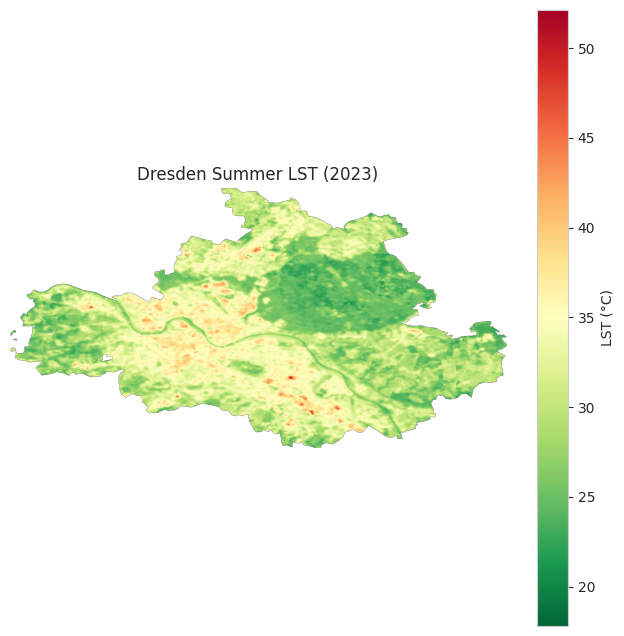

In [110]:
# Static Visualization of Summer 2023 Land Surface Temperature
import rasterio
import matplotlib.pyplot as plt

# Path to your exported LST raster
path = "/content/drive/MyDrive/GEE_exports/Dresden_LST_2023_summer.tif"

# Read raster
with rasterio.open(path) as src:
    lst = src.read(1)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(lst, cmap="RdYlGn_r")
plt.colorbar(label="LST (°C)")
plt.title("Dresden Summer LST (2023)")
plt.axis("off")
plt.show()


In [111]:
# Sentinel-1 SAR Backscatter Processing and VV/VH Ratio Derivation (Summer 2023)
s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filterBounds(aoi)
      .filterDate('2023-06-01', '2023-08-31')
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
      .select(['VV', 'VH']))

s1_median = s1.median().clip(aoi)

vv = s1_median.select('VV')
vh = s1_median.select('VH')
ratio = vv.subtract(vh).rename('VVVH_ratio')


In [112]:
# Export of Sentinel-1 SAR Backscatter and VV/VH Ratio Products
for band, name in [(vv, "VV"), (vh, "VH"), (ratio, "VVVH_ratio")]:
    task = ee.batch.Export.image.toDrive(
        image=band,
        description=f"Dresden_{name}_2023_summer",
        folder="GEE_exports",
        fileNamePrefix=f"Dresden_{name}_2023_summer",
        region=aoi,
        scale=10,
        maxPixels=1e13
    )
    task.start()


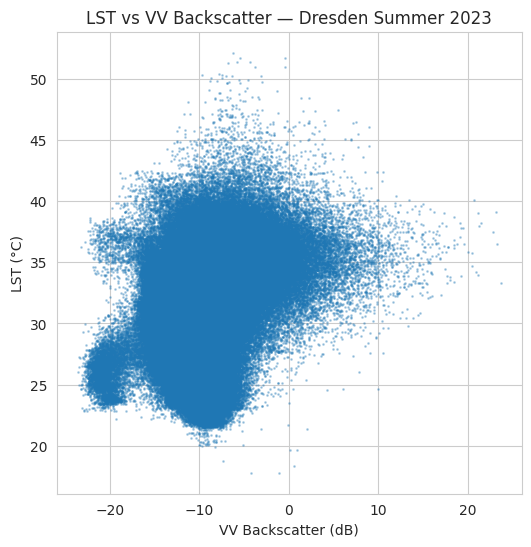

In [113]:
# Relationship Between Land Surface Temperature and Sentinel-1 VV Backscatter
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling

# Path to your exported LST and VV rasters
lst_path = "/content/drive/MyDrive/GEE_exports/Dresden_LST_2023_summer.tif"
vv_path = "/content/drive/MyDrive/GEE_exports/Dresden_VV_2023_summer.tif"

# Load LST raster and get its metadata for alignment
with rasterio.open(lst_path) as lst_src:
    lst = lst_src.read(1)
    lst_profile = lst_src.profile

# Load VV raster
with rasterio.open(vv_path) as vv_src:
    vv_original = vv_src.read(1)

    # Prepare an empty array for the resampled VV data with the shape of LST
    vv = np.empty_like(lst)

    # Reproject/Resample VV to match LST's transform and shape
    reproject(
        source=vv_original,
        destination=vv,
        src_transform=vv_src.transform,
        src_crs=vv_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Flatten and remove NaN values from both arrays where they align
mask = ~np.isnan(lst) & ~np.isnan(vv)
lst_flat = lst[mask]
vv_flat = vv[mask]

plt.figure(figsize=(6,6))
plt.scatter(vv_flat, lst_flat, s=1, alpha=0.3)
plt.xlabel("VV Backscatter (dB)")
plt.ylabel("LST (°C)")
plt.title("LST vs VV Backscatter — Dresden Summer 2023")
plt.show()

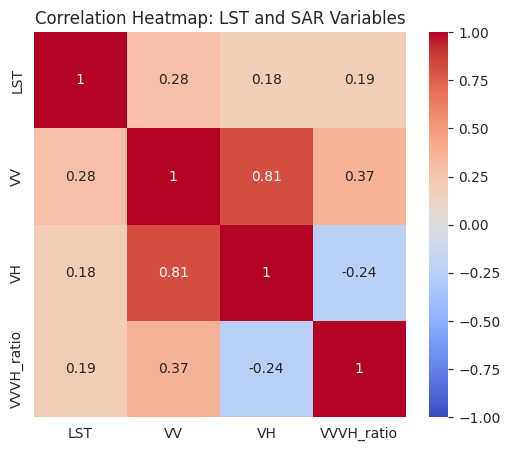

In [114]:
# Correlation Analysis Between Land Surface Temperature and Sentinel-1 SAR Variables
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import pandas as pd

# Define paths to exported rasters
lst_path = "/content/drive/MyDrive/GEE_exports/Dresden_LST_2023_summer.tif"
vv_path = "/content/drive/MyDrive/GEE_exports/Dresden_VV_2023_summer.tif"
vh_path = "/content/drive/MyDrive/GEE_exports/Dresden_VH_2023_summer.tif"

# Load LST raster and get its metadata for alignment
with rasterio.open(lst_path) as lst_src:
    lst = lst_src.read(1)
    lst_profile = lst_src.profile

# Load VV raster and resample to match LST's transform and shape
with rasterio.open(vv_path) as vv_src:
    vv_original = vv_src.read(1)
    vv = np.empty_like(lst) # Prepare an empty array for the resampled VV data

    reproject(
        source=vv_original,
        destination=vv,
        src_transform=vv_src.transform,
        src_crs=vv_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Load VH raster and resample to match LST's transform and shape
with rasterio.open(vh_path) as vh_src:
    vh_original = vh_src.read(1)
    vh = np.empty_like(lst) # Prepare an empty array for the resampled VH data

    reproject(
        source=vh_original,
        destination=vh,
        src_transform=vh_src.transform,
        src_crs=vh_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Flatten and mask
mask = ~np.isnan(lst) & ~np.isnan(vv) & ~np.isnan(vh)
data = np.vstack([lst[mask], vv[mask], vh[mask], (vv[mask] - vh[mask])]).T

df = pd.DataFrame(data, columns=["LST", "VV", "VH", "VVVH_ratio"])

corr = df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: LST and SAR Variables")
plt.show()

In [115]:
# Rule-Based Built-Up Area Classification Using Sentinel-1 VV–VH Backscatter Difference
import rasterio
import numpy as np

# Load VV and VH rasters
vv_path = "/content/drive/MyDrive/GEE_exports/Dresden_VV_2023_summer.tif"
vh_path = "/content/drive/MyDrive/GEE_exports/Dresden_VH_2023_summer.tif"

with rasterio.open(vv_path) as src:
    vv = src.read(1)

with rasterio.open(vh_path) as src:
    vh = src.read(1)

# Compute VV–VH ratio
ratio = vv - vh

# Classification threshold
threshold = 2  # dB

# Create classes
# 1 = built-up, 0 = other
builtup_mask = (ratio > threshold).astype(int)

print("Classification complete.")


Classification complete.


In [116]:
# Integration of Land Surface Temperature and Sentinel-1 SAR Data for Built-Up Area Analysis
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

lst_path = "/content/drive/MyDrive/GEE_exports/Dresden_LST_2023_summer.tif"
vv_path = "/content/drive/MyDrive/GEE_exports/Dresden_VV_2023_summer.tif"
vh_path = "/content/drive/MyDrive/GEE_exports/Dresden_VH_2023_summer.tif"

# Load LST raster and get its metadata for alignment
with rasterio.open(lst_path) as lst_src:
    lst = lst_src.read(1)
    lst_profile = lst_src.profile

# Load VV raster and resample to match LST's transform and shape
with rasterio.open(vv_path) as vv_src:
    vv_original = vv_src.read(1)
    vv = np.empty_like(lst) # Prepare an empty array for the resampled VV data

    reproject(
        source=vv_original,
        destination=vv,
        src_transform=vv_src.transform,
        src_crs=vv_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Load VH raster and resample to match LST's transform and shape
with rasterio.open(vh_path) as vh_src:
    vh_original = vh_src.read(1)
    vh = np.empty_like(lst) # Prepare an empty array for the resampled VH data

    reproject(
        source=vh_original,
        destination=vh,
        src_transform=vh_src.transform,
        src_crs=vh_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Compute VV–VH ratio with resampled data
ratio = vv - vh

# Classification threshold (from aIOIvCTYesS1, assuming it's available in context or needs to be defined)
threshold = 2  # dB

# Create built-up mask (from aIOIvCTYesS1)
builtup_mask = (ratio > threshold).astype(int)

# Mask invalid values (using resampled data)
valid = ~np.isnan(lst) & ~np.isnan(vv) & ~np.isnan(vh)

lst_valid = lst[valid]
vv_valid = vv[valid]
vh_valid = vh[valid]
ratio_valid = ratio[valid]
mask_valid = builtup_mask[valid]


/tmp/ipython-input-941971435.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([lst_built, lst_other], labels=["Built-up", "Other"])


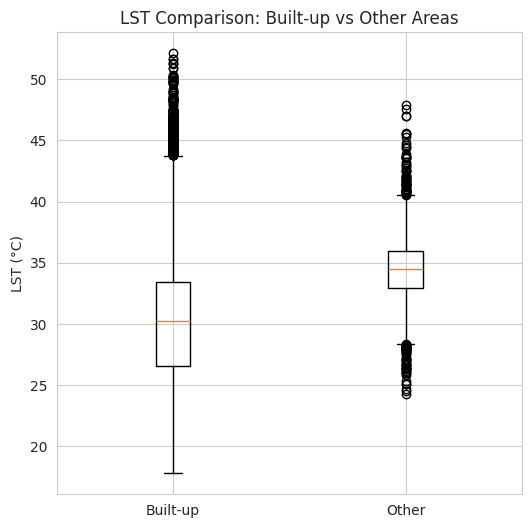

/tmp/ipython-input-941971435.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vv_built, vv_other], labels=["Built-up", "Other"])


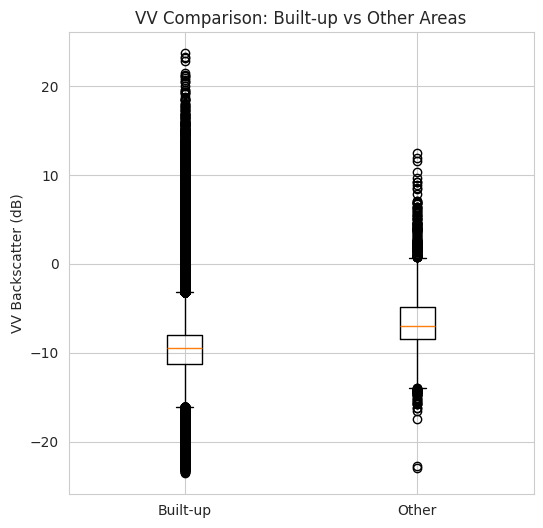

In [117]:
# Comparison of Land Surface Temperature and VV Backscatter Between Built-Up and Non-Built-Up Areas
import matplotlib.pyplot as plt

# Split into built-up and other
lst_built = lst_valid[mask_valid == 1]
lst_other = lst_valid[mask_valid == 0]

vv_built = vv_valid[mask_valid == 1]
vv_other = vv_valid[mask_valid == 0]

# --- LST Boxplot ---
plt.figure(figsize=(6,6))
plt.boxplot([lst_built, lst_other], labels=["Built-up", "Other"])
plt.ylabel("LST (°C)")
plt.title("LST Comparison: Built-up vs Other Areas")
plt.show()

# --- VV Boxplot ---
plt.figure(figsize=(6,6))
plt.boxplot([vv_built, vv_other], labels=["Built-up", "Other"])
plt.ylabel("VV Backscatter (dB)")
plt.title("VV Comparison: Built-up vs Other Areas")
plt.show()


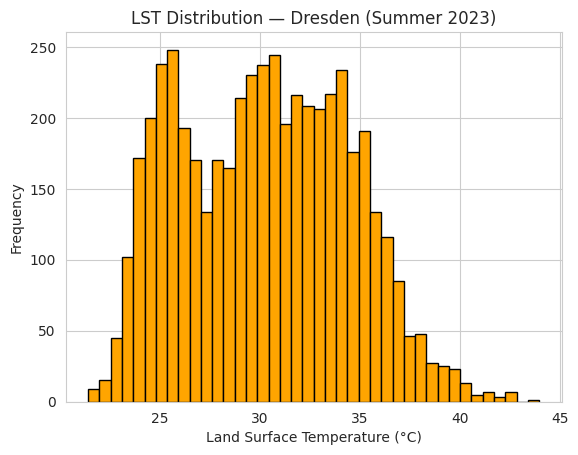

In [118]:

# Sampling and Distribution Analysis of Land Surface Temperature
# ---------------------------------------------------------
# 3. Sample LST for plotting
# ---------------------------------------------------------
samples = lst_celsius.sample(
    region=aoi,
    scale=30,
    numPixels=5000,
    geometries=False
)

# Convert to Pandas
import pandas as pd
df = samples.getInfo()
df = pd.DataFrame([f['properties'] for f in df['features']])

# ---------------------------------------------------------
# 4. Plot LST distribution (Histogram)
# ---------------------------------------------------------
import matplotlib.pyplot as plt

plt.hist(df['LST_C'], bins=40, color='orange', edgecolor='black')
plt.xlabel('Land Surface Temperature (°C)')
plt.ylabel('Frequency')
plt.title('LST Distribution — Dresden (Summer 2023)')
plt.grid(True)
plt.show()


In [119]:
# Integration and Preprocessing of LST and Sentinel-1 SAR Data for Pixel-Wise Analysis
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling

# Paths
vv_path = "/content/drive/MyDrive/GEE_exports/Dresden_VV_2023_summer.tif"
vh_path = "/content/drive/MyDrive/GEE_exports/Dresden_VH_2023_summer.tif"
lst_path = "/content/drive/MyDrive/GEE_exports/Dresden_LST_2023_summer.tif"

# Load LST raster and get its metadata for alignment
with rasterio.open(lst_path) as lst_src:
    lst = lst_src.read(1)
    lst_profile = lst_src.profile

# Load VV raster and resample to match LST's transform and shape
with rasterio.open(vv_path) as vv_src:
    vv_original = vv_src.read(1)
    vv = np.empty_like(lst) # Prepare an empty array for the resampled VV data

    reproject(
        source=vv_original,
        destination=vv,
        src_transform=vv_src.transform,
        src_crs=vv_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Load VH raster and resample to match LST's transform and shape
with rasterio.open(vh_path) as vh_src:
    vh_original = vh_src.read(1)
    vh = np.empty_like(lst) # Prepare an empty array for the resampled VH data

    reproject(
        source=vh_original,
        destination=vh,
        src_transform=vh_src.transform,
        src_crs=vh_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Compute VV–VH ratio
ratio = vv - vh

# Valid mask
valid = ~np.isnan(lst) & ~np.isnan(vv) & ~np.isnan(vh)

lst_valid = lst[valid]
vv_valid = vv[valid]
vh_valid = vh[valid]
ratio_valid = ratio[valid]

In [120]:
threshold = 2  # dB

builtup_mask = (ratio > threshold).astype(int)
mask_valid = builtup_mask[valid]

print("Built-up vs other classification complete.")


Built-up vs other classification complete.


/tmp/ipython-input-2734906009.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([vh_built, vh_other], labels=["Built-up", "Other"])


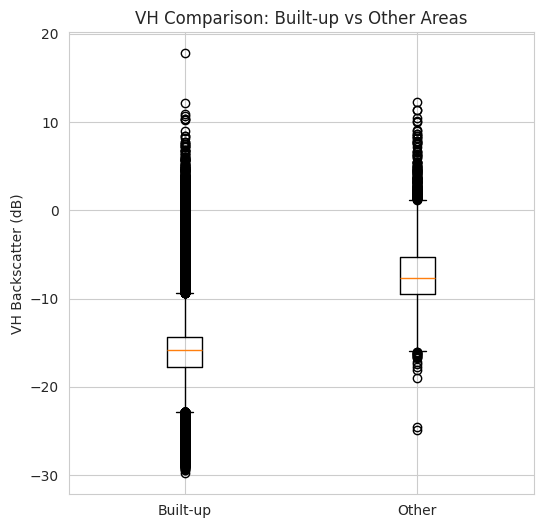

In [121]:
import matplotlib.pyplot as plt

vh_built = vh_valid[mask_valid == 1]
vh_other = vh_valid[mask_valid == 0]

plt.figure(figsize=(6,6))
plt.boxplot([vh_built, vh_other], labels=["Built-up", "Other"])
plt.ylabel("VH Backscatter (dB)")
plt.title("VH Comparison: Built-up vs Other Areas")
plt.show()


In [122]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

# Compute VV–VH ratio
ratio = vv - vh

# Mask invalid
valid = ~np.isnan(ratio)
ratio_valid = ratio[valid]

# Compute Otsu threshold
otsu_thresh = threshold_otsu(ratio_valid)
print("Otsu threshold:", otsu_thresh)

# Classification
builtup_mask = (ratio > otsu_thresh).astype(int)


Otsu threshold: 8.062660300897912


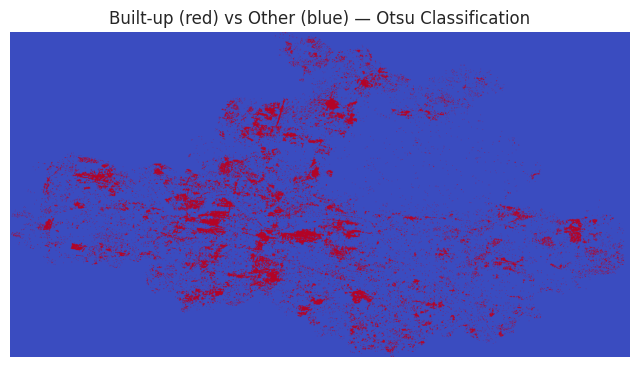

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(builtup_mask, cmap="coolwarm")
plt.title("Built-up (red) vs Other (blue) — Otsu Classification")
plt.axis("off")
plt.show()


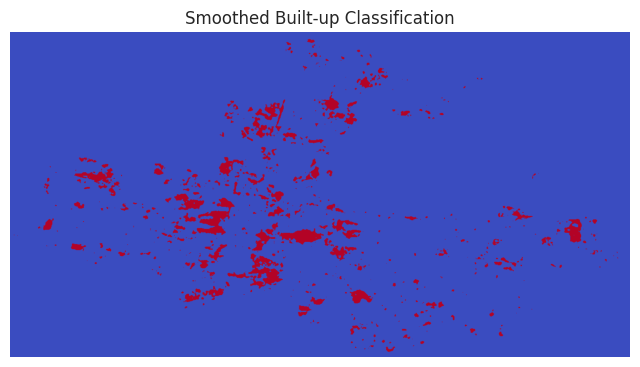

In [123]:
from scipy.ndimage import median_filter

builtup_smooth = median_filter(builtup_mask, size=5)

plt.figure(figsize=(8,8))
plt.imshow(builtup_smooth, cmap="coolwarm")
plt.title("Smoothed Built-up Classification")
plt.axis("off")
plt.show()


In [124]:
ndbi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['0000ff', '90ee90', 'a52a2a', '654321']
}

# Calculate NDBI using SWIR1 (SR_B6) and NIR (SR_B5) bands
# Assuming 'median_image' is still available from previous NDVI calculation
ndbi = median_image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

# Get the Earth Engine map ID and token for the NDBI image
map_id_ndbi_dict = ndbi.getMapId(ndbi_vis)

# Create a Folium TileLayer using the GEE tile URL and add it to the map.
folium.TileLayer(
    tiles=map_id_ndbi_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='NDBI'
).add_to(Map)



In [125]:
rgb_vis = {
    'bands': ['SR_B4','SR_B3','SR_B2'], # Using SR_B4 (Red), SR_B3 (Green), SR_B2 (Blue) for natural color
    'min': 0.0,
    'max': 0.3
}

# Get the Earth Engine map ID and token for the median_image (our 'natural color' composite)
map_id_rgb_dict = median_image.getMapId(rgb_vis)

# Create a Folium TileLayer using the GEE tile URL and add it to the map.
folium.TileLayer(
    tiles=map_id_rgb_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Natural Color'
).add_to(Map)

# Optionally, re-display the map to see the new layer immediately
# display(Map)

In [126]:
import ee

# Assuming 'ndbi' (ee.Image) and 'aoi' (ee.Geometry) are already defined
# (from previous cells BnjhTYLechsr and Y2nZ8cBeDL_C respectively).

task = ee.batch.Export.image.toDrive(
    image=ndbi,
    description='Dresden_NDBI_2023_summer',
    folder='GEE_exports',
    fileNamePrefix='Dresden_NDBI_2023_summer',
    region=aoi,
    scale=30, # Match Landsat resolution
    maxPixels=1e13
)

task.start()
print("Export started: Dresden_NDBI_2023_summer.tif")

Export started: Dresden_NDBI_2023_summer.tif


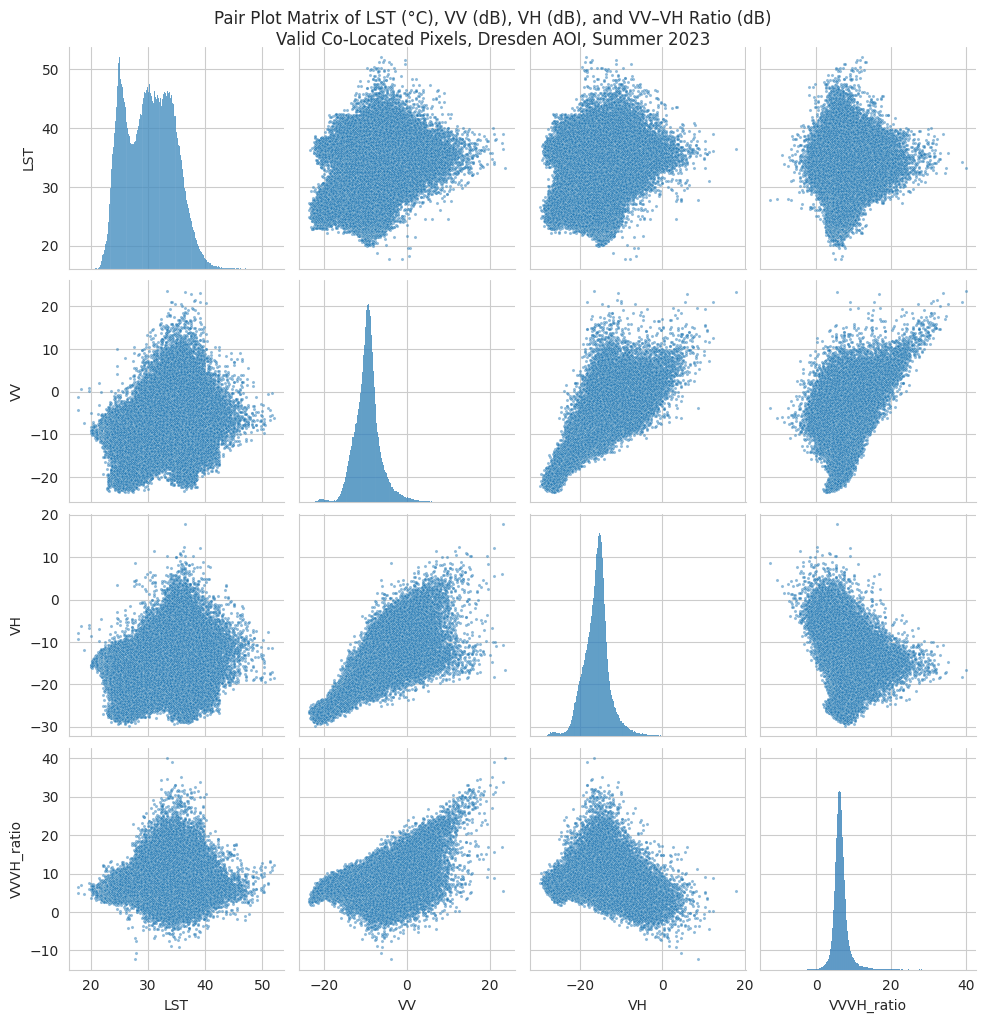

In [127]:
# Load VH raster and resample to match LST's transform and shape
with rasterio.open(vh_path) as vh_src:
    vh_original = vh_src.read(1)
    vh = np.empty_like(lst) # Prepare an empty array for the resampled VH data

    reproject(
        source=vh_original,
        destination=vh,
        src_transform=vh_src.transform,
        src_crs=vh_src.crs,
        dst_transform=lst_profile['transform'],
        dst_crs=lst_profile['crs'],
        resampling=Resampling.average
    )

# Flatten and mask
mask = ~np.isnan(lst) & ~np.isnan(vv) & ~np.isnan(vh)
data = np.vstack([lst[mask], vv[mask], vh[mask], (vv[mask] - vh[mask])]).T

# Create the DataFrame
df = pd.DataFrame(data, columns=["LST", "VV", "VH", "VVVH_ratio"])

sns.set_style("whitegrid")

pair = sns.pairplot(
    df[["LST", "VV", "VH", "VVVH_ratio"]],
    diag_kind="hist",      # histograms on diagonal
    corner=False,          # full matrix
    plot_kws={"s": 5, "alpha": 0.5}  # small, semi‑transparent points
)

pair.fig.suptitle(
    "Pair Plot Matrix of LST (°C), VV (dB), VH (dB), and VV–VH Ratio (dB)\n"
    "Valid Co‑Located Pixels, Dresden AOI, Summer 2023",
    y=1.02
)

plt.show()
